# Movie Recommender

This Jupyter Notebook creates a Recommender System using PySpark and the [MovieLens](https://grouplens.org/datasets/movielens/) dataset from GroupLens.   It uses the small dataset for education and development, which contains ~100,000 ratings from ~9,000 movies by ~600 users.  It was last updated September 2018 (as of 3/3/2022).  The ratings were created between March 29th, 1996 and September 24th, 2018.  More information can be found [here](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html).

We are interested in creating a recommender system that can accurately predict the ratings of movies for a given user.  We will be using collaborative-filtering first.

**Note**: The culmination of this project is a separate journal-formatted paper, so this Jupyter Notebook will have less text than usual.

## Configuration:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
INPUT_DIRECTORY = "/content/drive/MyDrive/Grad School/DSCI 632/MovieRecommender/data/" #for google mount
# INPUT_DIRECTORY = "./data/" #for jupyter notebook

In [3]:
%%capture 
#prevent large printout with %%capture

#Download Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Install Apache Spark 3.2.1 with Hadoop 3.2, get zipped folder
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

#Unzip folder
!tar xvf spark-3.2.1-bin-hadoop3.2.tgz

#Install findspark, pyspark 3.2.1
!pip install -q findspark
!pip install pyspark==3.2.1

#Set variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.1-bin-hadoop3.2"

## Load Packages and Functions

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType
import textwrap

In [67]:
def calculate_sparsity(spark_df, rating_col="rating", userId_col="userId", movieId_col="movieId"):
  """PURPOSE: Calculates sparsity for a given PySpark DataFrame.  If a DataFrame has 100% 
  sparsity, it is 100% empty.  Sparsity is calculated by getting the number of total ratings 
  and dividing by the total number of possible ratings and converting to a percentage.
  
  PARAMETERS:
  ------------
  spark_df : PySpark DataFrame
      Name of df 
  rating_col : str , default "rating"
      name of column with ratings data, by default
  userId_col : str , default "userId"
      name of column with user IDs
  movieId_col : str , default "movieId"
      Name of column with movie IDs""" 

  #get number of ratings in dataset
  numerator = spark_df.select(rating_col).count()

  #get number of distinct users and movies
  users_count = ratings.select(userId_col).distinct().count()
  movies_count = ratings.select(movieId_col).distinct().count()

  #get number of total possible ratings
  denominator = users_count * movies_count

  #calculate sparsity (num ratings / num possible ratings)
  sparsity = (1.0 - (numerator*1.0) / denominator) * 100
  print(f"The ratings dataframe is {sparsity:.2f}% empty.")

In [66]:
import numpy as np
import textwrap

def get_formatted_columns(titles):
  """PURPOSE: Reformats a pandas df column with type string with newline inserts (\n) 
  to ensure the length of each string is equal when printed on a figure.  
  (Helps to evenly space labels)
  
  PARAMETERS:
  ------------
  titles : pandas Series or list
      pandas column to reformat""" 


  mean_length = np.mean([len(i) for i in titles]) 
  titles = ["\n".join(textwrap.wrap(i,mean_length)) for i in titles]
  return titles

## Import Data and Preprocessing


### Import Data

In [7]:
#create SparkSession and SparkContext objects
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [8]:
#Import data
file_path = INPUT_DIRECTORY + "ratings.csv"
ratings = spark.read.csv(file_path, header=True, inferSchema=True)
ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [9]:
print(f"Number of ratings: {ratings.count()}")
print(f"Number of distinct users: {ratings.select('userId').distinct().count()}")
print(f"Number of distinct movies: {ratings.select('movieId').distinct().count()}")

Number of ratings: 100836
Number of distinct users: 610
Number of distinct movies: 9724


### Preprocessing

#### Check datatypes

In [10]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



#### No duplicate ratings

Now let's confirm there are no duplicates of `movieId` and `userId` (i.e. no double ratings for a given movie-user pair):

In [39]:
ratings.groupby("userId", "movieId").count().select(F.max("count")).show()

+----------+
|max(count)|
+----------+
|         1|
+----------+



Each user-movie pair has only one rating.

#### Sparsity

As a last quality check, we'll see how sparse our dataset is:


In [12]:
calculate_sparsity(ratings)

The ratings dataframe is 98.30% empty.


Recommender Systems usually have about 99% sparsity, so this is normal, if not more populated than usual.

#### Join data for readability

`userId`, `movieId`, and `rating` are of the appropriate datatypes to continue analysis.  We'll join `ratings` with the actual movie titles for readability purposes:

In [13]:
#Import movie titles
file_path = INPUT_DIRECTORY + "movies.csv"
titles = spark.read.csv(file_path, header=True, inferSchema=True)
titles = titles.select("movieId", "title") #remove genres
titles.show(5, truncate=False)

+-------+----------------------------------+
|movieId|title                             |
+-------+----------------------------------+
|1      |Toy Story (1995)                  |
|2      |Jumanji (1995)                    |
|3      |Grumpier Old Men (1995)           |
|4      |Waiting to Exhale (1995)          |
|5      |Father of the Bride Part II (1995)|
+-------+----------------------------------+
only showing top 5 rows



In [14]:
movie_ratings = ratings.join(titles, on="movieId", how="left")
movie_ratings.show(5, truncate=False)

+-------+------+------+---------+---------------------------+
|movieId|userId|rating|timestamp|title                      |
+-------+------+------+---------+---------------------------+
|1      |1     |4.0   |964982703|Toy Story (1995)           |
|3      |1     |4.0   |964981247|Grumpier Old Men (1995)    |
|6      |1     |4.0   |964982224|Heat (1995)                |
|47     |1     |5.0   |964983815|Seven (a.k.a. Se7en) (1995)|
|50     |1     |5.0   |964982931|Usual Suspects, The (1995) |
+-------+------+------+---------+---------------------------+
only showing top 5 rows



Next we'll convert the `timestamp` from unix seconds since 1/1/1970 to a more readable `date`:

In [15]:
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType

movie_ratings = movie_ratings.withColumn("timestamp", F.from_unixtime("timestamp"))
movie_ratings.show()

+-------+------+------+-------------------+--------------------+
|movieId|userId|rating|          timestamp|               title|
+-------+------+------+-------------------+--------------------+
|      1|     1|   4.0|2000-07-30 18:45:03|    Toy Story (1995)|
|      3|     1|   4.0|2000-07-30 18:20:47|Grumpier Old Men ...|
|      6|     1|   4.0|2000-07-30 18:37:04|         Heat (1995)|
|     47|     1|   5.0|2000-07-30 19:03:35|Seven (a.k.a. Se7...|
|     50|     1|   5.0|2000-07-30 18:48:51|Usual Suspects, T...|
|     70|     1|   3.0|2000-07-30 18:40:00|From Dusk Till Da...|
|    101|     1|   5.0|2000-07-30 18:14:28|Bottle Rocket (1996)|
|    110|     1|   4.0|2000-07-30 18:36:16|   Braveheart (1995)|
|    151|     1|   5.0|2000-07-30 19:07:21|      Rob Roy (1995)|
|    157|     1|   5.0|2000-07-30 19:08:20|Canadian Bacon (1...|
|    163|     1|   5.0|2000-07-30 19:00:50|    Desperado (1995)|
|    216|     1|   5.0|2000-07-30 18:20:08|Billy Madison (1995)|
|    223|     1|   3.0|20

Finally, we'll reorganize the columns for ALS:

In [16]:
movie_ratings = movie_ratings.select("title", "movieId", "userId", "rating", "timestamp")
movie_ratings.show(5, truncate=False)

+---------------------------+-------+------+------+-------------------+
|title                      |movieId|userId|rating|timestamp          |
+---------------------------+-------+------+------+-------------------+
|Toy Story (1995)           |1      |1     |4.0   |2000-07-30 18:45:03|
|Grumpier Old Men (1995)    |3      |1     |4.0   |2000-07-30 18:20:47|
|Heat (1995)                |6      |1     |4.0   |2000-07-30 18:37:04|
|Seven (a.k.a. Se7en) (1995)|47     |1     |5.0   |2000-07-30 19:03:35|
|Usual Suspects, The (1995) |50     |1     |5.0   |2000-07-30 18:48:51|
+---------------------------+-------+------+------+-------------------+
only showing top 5 rows



## EDA

### Movie and User Summary Statistics

Let's see the top movies and users:

In [17]:
movie_ratings.select("title", "movieId").groupBy("title") \ 
    .count().orderBy("count", ascending=False).show(20, truncate=False)

+------------------------------------------------------------------------------+-----+
|title                                                                         |count|
+------------------------------------------------------------------------------+-----+
|Forrest Gump (1994)                                                           |329  |
|Shawshank Redemption, The (1994)                                              |317  |
|Pulp Fiction (1994)                                                           |307  |
|Silence of the Lambs, The (1991)                                              |279  |
|Matrix, The (1999)                                                            |278  |
|Star Wars: Episode IV - A New Hope (1977)                                     |251  |
|Jurassic Park (1993)                                                          |238  |
|Braveheart (1995)                                                             |237  |
|Terminator 2: Judgment Day (1991)         

In [68]:
movie_ratings.groupBy("userId").count().orderBy("count", ascending=False).show(10, truncate=False)

+------+-----+
|userId|count|
+------+-----+
|414   |2698 |
|599   |2478 |
|474   |2108 |
|448   |1864 |
|274   |1346 |
|610   |1302 |
|68    |1260 |
|380   |1218 |
|606   |1115 |
|288   |1055 |
+------+-----+
only showing top 10 rows



Next, we'll identify the first and last rating `timestamp`:

In [19]:
movie_ratings.select(F.min("timestamp")).show()

+-------------------+
|     min(timestamp)|
+-------------------+
|1996-03-29 18:36:55|
+-------------------+



In [20]:
movie_ratings.select(F.max("timestamp")).show()

+-------------------+
|     max(timestamp)|
+-------------------+
|2018-09-24 14:27:30|
+-------------------+



### Visualizations in `matplotlib`

#### Plotting all Data

We'll now convert the PySpark DataFrames from above to `pandas` DataFrames to create some visualizations:

In [21]:
pandas_movie_ratings = movie_ratings.toPandas()
pandas_movie_ratings.head()

,title,movieId,userId,rating,timestamp
0,Toy Story (1995),1,1,4.0,2000-07-30 18:45:03
1,Grumpier Old Men (1995),3,1,4.0,2000-07-30 18:20:47
2,Heat (1995),6,1,4.0,2000-07-30 18:37:04
3,Seven (a.k.a. Se7en) (1995),47,1,5.0,2000-07-30 19:03:35
4,"Usual Suspects, The (1995)",50,1,5.0,2000-07-30 18:48:51


In [22]:
movie_titles = titles.toPandas()
movie_titles.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [23]:
#get copy of pandas df
pandas_movie = pandas_movie_ratings.copy()

#count num ratings in each movie, get only movie and userid columns
pandas_movie_ind = pandas_movie.groupby("movieId", as_index=False).count()[["movieId", "userId"]]

#merge tables to get titles (groupby deletes title index values)
pandas_movie_counts = movie_titles.merge(pandas_movie_ind, on="movieId")

#set index to titles for plotting
pandas_movie_counts = pandas_movie_counts.set_index("title")

#rename columns for readability
pandas_movie_counts = pandas_movie_counts.rename(columns={"userId": "num_ratings"})
pandas_movie_counts.head()

,movieId,num_ratings
title,,
Toy Story (1995),1,215
Jumanji (1995),2,110
Grumpier Old Men (1995),3,52
Waiting to Exhale (1995),4,7
Father of the Bride Part II (1995),5,49


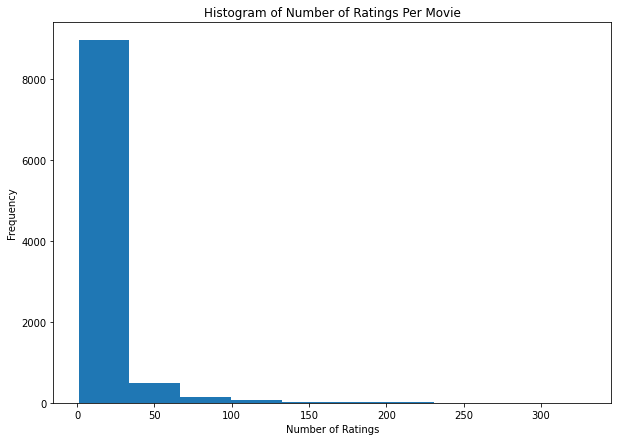

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(pandas_movie_counts.num_ratings)

#customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Histogram of Number of Ratings Per Movie")
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Frequency")
plt.show()

In [37]:
#get copy of pandas df
pandas_user = pandas_movie_ratings.copy()

#count num ratings in each movie, get only movie and userid columns
pandas_user_ind = pandas_user.groupby("userId", as_index=False).count()[["userId", "rating"]]

#rename columns for readability
pandas_user_counts = pandas_user_ind.rename(columns={"rating": "num_ratings"})
pandas_user_counts.head()

,userId,num_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


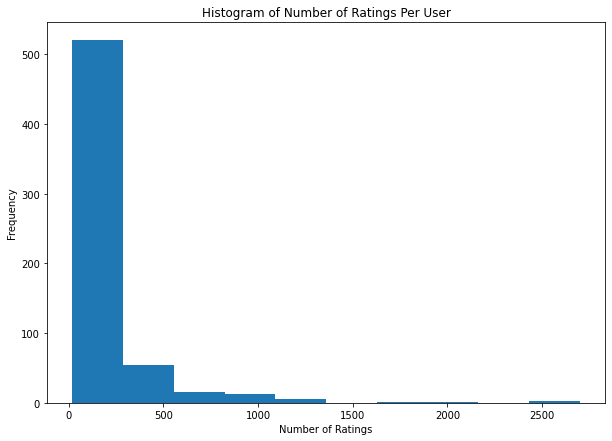

In [40]:
fig, ax = plt.subplots()

ax.hist(pandas_user_counts.num_ratings)

#customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Histogram of Number of Ratings Per User")
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Frequency")
plt.show()

#### Plotting Top Movies and Users

In [51]:
top_movies = movie_ratings.select("title", "movieId").groupBy("title") \
    .count().orderBy("count", ascending=False).toPandas()
top_movies = top_movies.iloc[:10,:]
top_movies.head()

,title,count
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278


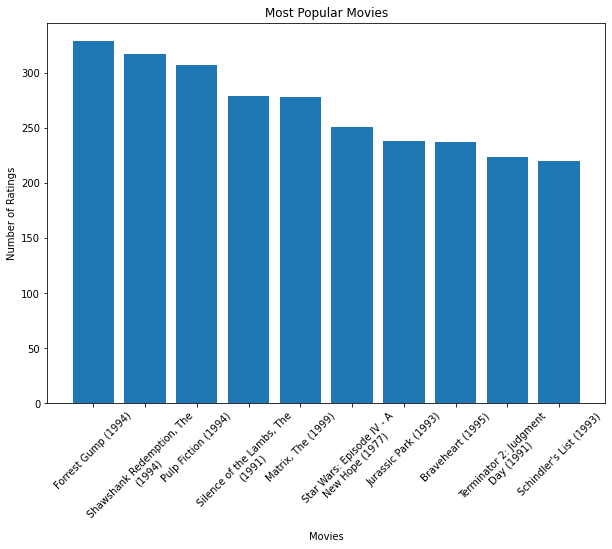

In [74]:
fig, ax = plt.subplots()

ax.bar(x=top_movies["title"], height=top_movies["count"])

#customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Most Popular Movies")
ax.set_xlabel("Movies")
ax.set_ylabel("Number of Ratings")
ax.set_xticklabels(get_formatted_columns(top_movies["title"]), rotation=45)
plt.show()

In [81]:
top_users = movie_ratings.select("userId", "rating").groupBy("userId") \
    .count().orderBy("count", ascending=False).toPandas()
top_users = top_users.iloc[:10,:]   #get top 10 users
top_users.userId = top_users.userId.astype(str)
top_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  10 non-null     object
 1   count   10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


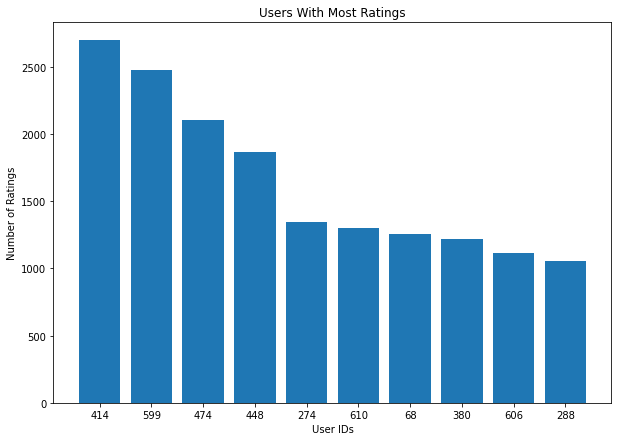

In [86]:
#plot top users
fig, ax = plt.subplots()

ax.bar(x=top_users["userId"], height=top_users["count"])

#customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Users With Most Ratings")
ax.set_xlabel("User IDs")
ax.set_ylabel("Number of Ratings")
ax.set_xticklabels(top_users["userId"])
plt.show()

#### Movies By Year

## ALS Model Creation

We'll split our data 80/20% into training/testing sets and set `seed` to 1 for reproducibility:

In [27]:
training_data, test_data = movie_ratings.randomSplit([.8, .2], seed=1)

## Performance Evaluation